# CIFAR 10

In [0]:
import numpy as np
import os

from matplotlib import pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.initializers import glorot_normal, RandomNormal
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

def load_data(test_split=0.2, verbose=True):
    """load the raw data
    
    Keyword Arguments:
        test_split {float} -- [description] (default: {0.2})
        verbose {bool} -- output dataset details (default: {True})

    return:
        (x_train, y_train, x_test, y_test)
    """    
    # load raw data
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    return (x_train, y_train, x_test, y_test)


def preprocessing(x_train, y_train, x_test, y_test, verbose=True):
    # Normalization
    mean = np.mean(x_train, axis=(0,1,2,3))
    std = np.std(x_train, axis=(0,1,2,3))
    x_train = (x_train - mean) / (std+1e-7)
    x_test = (x_test - mean) / (std+1e-7)

    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    if verbose:
        print(
            f"Shape of x_train: {x_train.shape}, Shape of y_train: {y_train.shape}\n" +
            f"Shape of x_test:  {x_test.shape }, Shape of y_test:  {y_test.shape}\n"
        )

    return x_train, y_train, x_test, y_test


def get_model(x_train, strides=2, weight_decay = 1e-2, act="relu"):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3,3), padding='same', kernel_initializer=glorot_normal(), input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 2
    model.add(Conv2D(128, (3,3), padding='same', kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 3
    model.add(Conv2D(128, (3,3), padding='same', kernel_initializer=RandomNormal(stddev=0.01)))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 4
    model.add(Conv2D(128, (3,3), padding='same', kernel_initializer=RandomNormal(stddev=0.01)))
    model.add(BatchNormalization())
    model.add(Activation(act))
    # First Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=strides))
    model.add(Dropout(0.2))
    
    
    # Block 5
    model.add(Conv2D(128, (3,3), padding='same', kernel_initializer=RandomNormal(stddev=0.01)))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 6
    model.add(Conv2D(128, (3,3), padding='same', kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 7
    model.add(Conv2D(256, (3,3), padding='same', kernel_initializer=glorot_normal()))
    # Second Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=strides))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    
    # Block 8
    model.add(Conv2D(256, (3,3), padding='same', kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 9
    model.add(Conv2D(256, (3,3), padding='same', kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    # Third Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=strides))
    
    
    # Block 10
    model.add(Conv2D(512, (3,3), padding='same', kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))

    # Block 11  
    model.add(Conv2D(2048, (1,1), padding='same', kernel_initializer=glorot_normal()))
    model.add(Activation(act))
    model.add(Dropout(0.2))
    
    # Block 12  
    model.add(Conv2D(256, (1,1), padding='same', kernel_initializer=glorot_normal()))
    model.add(Activation(act))
    # Fourth Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=strides))
    model.add(Dropout(0.2))


    # Block 13
    model.add(Conv2D(256, (3,3), padding='same', kernel_initializer=glorot_normal()))
    model.add(Activation(act))
    # Fifth Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=strides))

    # Final Classifier
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    opt_adm = Adadelta(lr=0.1) 
    model.compile(loss='categorical_crossentropy', optimizer=opt_adm, metrics=['accuracy'])

    return model


def fit_model(model, x_train, y_train, x_test, y_test, optimizer, img_gen, epochs, batch=128):
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy']
    )

    history = model.fit(
        img_gen.flow(x_train, y_train, batch_size=batch),
        steps_per_epoch = x_train.shape[0] // batch,
        validation_data = (x_test,y_test), 
        epochs = epochs
    )

    return (model, history)


def plot(history, title):
    fig, ax = plt.subplots(, 1, figsize=(7, 7), sharex=True)
    fig.suptitle(title)

    ax[0].plot(
        history['loss'], "red", 
        label=f"loss = {round(history['loss'][-1], 4)}"
    )
    ax[0].set_title("loss")
    
    accuracy = str(round(history['accuracy'][-1], 4))
    ax[1].plot(
        history['accuracy'], "blue", 
        label=f"accuracy = {accuracy}"
    )
    ax[1].set_title("accuracy")
    ax[1].set_xlabel("Iterations")
    fig.legend()

    plt.show()

In [2]:
def main(steps=4):
    # Load and preprocessing data
    x_train, y_train, x_test, y_test = preprocessing(*load_data())

    # Data augmentation
    img_gen = ImageDataGenerator(
        width_shift_range  = 0.1,
        height_shift_range = 0.1,
        rotation_range     = 15,
        horizontal_flip    = True
    )
    img_gen.fit(x_train)
    
    # Create model

    model = get_model(x_train)
    model.summary()

    # fit model and record history
    history = {}
    for step in range(1, steps + 1):

        learning_rate = 0.1 ** step
        optimizer = Adadelta(learning_rate)

        epochs = 50 if step == 1 else 25

        model, history[step] = fit_model(
            model, x_train, y_train, x_test, y_test, 
            optimizer = optimizer, 
            img_gen   = img_gen, 
            epochs    = epochs
        )

        model.evaluate(x_test, y_test)

    return model, history


if __name__ == "__main__":
    model_c10, history_c10 = main(steps=4)

170500096/170498071 [==============================] - 6s 0us/step
Dataset summary
-------------------------------
Shape of x_train: (50000, 32, 32, 3), Shape of y_train: (50000, 10)
Shape of x_test:  (10000, 32, 32, 3), Shape of y_test:  (10000, 10)

Model Summary
-------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)     

In [35]:
_, _, x_test, y_test = preprocessing(*load_data())

print("""\
Test set accuracy
-------------------------------""")
model_c10.evaluate(x_test, y_test)

Dataset summary
-------------------------------
Shape of x_train: (50000, 32, 32, 3), Shape of y_train: (50000, 10)
Shape of x_test:  (10000, 32, 32, 3), Shape of y_test:  (10000, 10)

Test set accuracy
-------------------------------
10000/10000 [==============================] - 3s 290us/sample - loss: 0.2715 - accuracy: 0.9112


[0.27146184172034266, 0.9112]

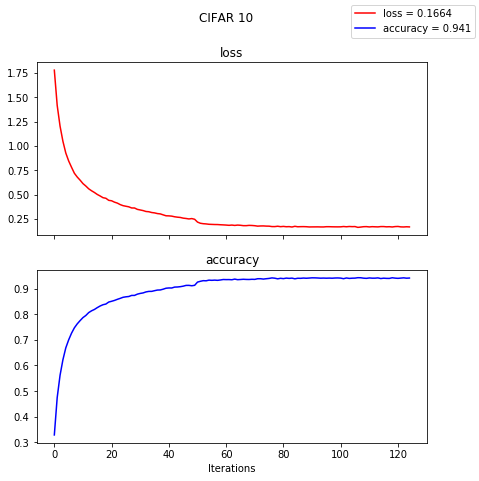

In [39]:
history_all = {}

for h in history_c10:
    h_dict = history_c10[h].history
    for k in h_dict:
        history_all[k] = history_all.get(k, []) + h_dict[k]

plot(history_all, "CIFAR 10")

# CIFAR 100

In [3]:
import numpy as np
import sys
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


def load_data(test_split=0.2, verbose=True):
    """load the raw data
    
    Keyword Arguments:
        test_split {float} -- [description] (default: {0.2})
        verbose {bool} -- output dataset details (default: {True})

    return:
        (x_train, y_train, x_test, y_test)
    """    
    # load raw data
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()

    return (x_train, y_train, x_test, y_test)


def preprocessing(x_train, y_train, x_test, y_test, verbose=True):
    # Normalization
    mean = np.mean(x_train, axis=(0,1,2,3))
    std  = np.std( x_train, axis=(0,1,2,3))
    x_train = (x_train - mean)/(std+1e-7)
    x_test  = (x_test  - mean)/(std+1e-7)

    y_train = to_categorical(y_train, 100)
    y_test  = to_categorical(y_test,  100)

    if verbose:
        print(
            f"Shape of x_train: {x_train.shape}, Shape of y_train: {y_train.shape}\n" +
            f"Shape of x_test:  {x_test.shape }, Shape of y_test:  {y_test.shape}\n"
        )

    return x_train, y_train, x_test, y_test

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot(history, title):
    plt.title(title)
    plt.xlabel('iteration')
    plt.ylabel('loss')

    plt.plot(
        history['loss'], 
        label=f"loss = {history['loss'][-1]}"
    )
    plt.legend()
    
    plt.show()



TensorFlow 2.x selected.


169009152/169001437 [==============================] - 6s 0us/step
Dataset summary
-------------------------------
Shape of x_train: (50000, 32, 32, 3), Shape of y_train: (50000, 100)
Shape of x_test:  (10000, 32, 32, 3), Shape of y_test:  (10000, 100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         


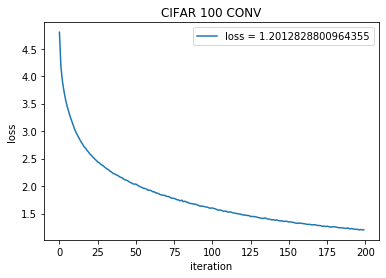

In [4]:
# load and preprocessing data
x_train, y_train, x_test, y_test = preprocessing(*load_data())

# # data augmentation
# img_gen = ImageDataGenerator(
#     width_shift_range  = 0.1,
#     height_shift_range = 0.1,
#     rotation_range     = 15,
#     horizontal_flip    = True
# )
# img_gen.fit(x_train)


# define model
model_c100 = define_model()
model_c100.summary()

# fit model
history_c100 = model_c100.fit(
    x_train, y_train, epochs=200, 
    batch_size=64, 
)

model_c100.save('model_c100.h5')

# plot history
plot(history_c100.history, title="CIFAR 100 CONV")

In [2]:
# plot history
plot(history_c100, title="CIFAR 100 CONV")

NameError: ignored

In [43]:
model_c100.evaluate(x_train_c100, y_train_c100)

50000/50000 [==============================] - 8s 158us/sample - loss: 1.5699 - accuracy: 0.5670


[1.5698779359817505, 0.56702]

In [1]:
from tensorflow.keras.utils import to_categorical

/Users/daniel/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/daniel/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/daniel/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/daniel

In [2]:
to_categorical([5,1,7,14],10)

IndexError: index 14 is out of bounds for axis 1 with size 10